In [1]:
# imports
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
# Terms of five bonds are given below
years = [1, 3, 5, 7, 10] # number of years
coupons = [4.125, 5.125, 6.125, 7.125, 8.0]  # in percent
prices = [103, 103.5, 112.5, 116, 118]
# all bonds are semi annual coupon paying bonds with notional of 100.0

### Steps
* Write a Bond class that takes coupon, frequency, maturity, notional to construct a bond.
* Generate bond Cashflows
* This class should have function to calculate PV given an interest rate
* Write another class with objective function
* Run Bisection, Secant and Newton solver, Plot error function.
* calculate YTM for the above bonds using solvers you have implemented. Make sure YTM is form each of the methods matches.


### Hints
* Remember Bond cash flow for semi annual bond per period is 1/2 of coupon * notional and last payment also has additional notional.
* PV of a bond is sum of presnt value of each cashflow.

In [3]:
class Bond(object):
    def __init__(self, coupon=None, frequency=None, maturity=None, notional=None):
        self.coupon = np.divide(coupon, 100) # coupon in rate, we assume input is in percent (eg. 4%)
        self.frequency = frequency # annual frequency is 1, semi annual frequency is 2, etc.
        self.maturity = maturity # maturity in years
        self.notional = notional # par value of the bond
        
    def present_value(self, YTM):
        # Returns: Present value in dollars given a YTM
        # We assume input is in percent (eg. 4%)
        YTM = np.divide(YTM, 100)
        # coupon * notional * 1/frequency for the coupon payment of a bond
        coupon_payment = np.prod([self.coupon, self.notional, np.divide(1, self.frequency)])
        # total number of payments is the frequency and maturity (eg. semi annual for three years is 6 payments)
        number_of_payments = np.multiply(self.maturity, self.frequency)
        # 1+ YTM/frequency
        discount_rate = np.add(1,np.divide(YTM,self.frequency))
        PV = 0
        for payment in range(1,number_of_payments+1):
            # discount for the number of terms for YTM
            total_discount_rate = np.power(discount_rate, payment)
            if payment == number_of_payments:
                # you get your notional back at the end
                total_coupon_payment = np.add(coupon_payment, self.notional)
            else: 
                total_coupon_payment = coupon_payment
            PV += np.divide(total_coupon_payment, total_discount_rate)
        return PV
    
    # Generates cashflow at period X given rate Y 
    def cashflow(self, period, rate):
        rate = np.divide(rate, 100)
        coupon_payment = np.prod([self.coupon, self.notional, np.divide(1, self.frequency)])
        if period == self.maturity:
            coupon_payment += self.notional
        discount_rate = np.add(1,np.divide(rate,self.frequency))
        total_discount_rate = np.power(discount_rate, period)
        cashflow = np.divide(coupon_payment, total_discount_rate)
        return cashflow

            
# *we assume rates are annual

In [4]:
# Test for bond value
# This is for a bond with a notional of 1000, a coupon rate of 4%, a maturity of 4 years
# that compounds annually with a YTM of 3%
Bond_A = Bond(coupon=4, frequency=1, maturity=4, notional=1000)
print("Present value given a YTM of 3%: $"+ str(Bond_A.present_value(3))) 
print("Cash flow at period 2 given a rate of 3%: $" + str(Bond_A.cashflow(2,3)))

Present value given a YTM of 3%: $1037.1709840281035
Cash flow at period 2 given a rate of 3%: $37.70383636535018


In [5]:
class Objective(object):
    # Output YTMs are in percentages, so 4 would be 4%
    def __init__(self, price=None, bond=None):
        self.price = price
        self.bond = bond
        self.numiter=0
        self.error = []
    
    def f_prime_pv(self, YTM):
        # using the macaulay duration here since it's fprime
        YTM = np.divide(YTM, 100)
        bond = self.bond
        number_of_payments = np.multiply(bond.maturity, bond.frequency)
        discount_rate = np.add(1,np.divide(YTM, bond.frequency))
        coupon_payment = np.prod([bond.coupon, bond.notional, np.divide(1, bond.frequency)])
        PV = 0
        for payment in range(1,number_of_payments+1):
            total_discount_rate = np.power(discount_rate, payment)
            if payment == number_of_payments:
                total_coupon_payment = np.add(coupon_payment, bond.notional)
            else: 
                total_coupon_payment = np.multiply(coupon_payment, payment)
            PV += np.divide(total_coupon_payment, total_discount_rate)
        return PV

    def clear_error(self):
        self.numiter = 0
        self.error =[]
        
    def optimize_function(self, YTM):
        # We are trying to optimize such that given a price, we determine the YTM by moving PV to price
        PV_function = np.subtract(self.price, self.bond.present_value(YTM))
        self.numiter += 1
        self.error.append(PV_function)
        return PV_function
    
    @property
    def bisection(self):
        try:
            root = optimize.bisect(self.optimize_function, 0, 15)
        except ValueError as err:
            print (err)
        return root
    
    @property
    def secant(self):
        try:
            root = optimize.newton(self.optimize_function, 0)
        except ValueError as err:
            print (err)
        return root
    
    @property
    def newton(self):
        try:
            root = optimize.newton(self.optimize_function, 0, fprime = self.f_prime_pv, tol=1e-9, maxiter=600)
        except ValueError as err:
            print (err)
        return root

In [6]:
Objective_Bond_A = Objective(price=1000, bond=Bond_A)
print("Bisection YTM: " + str(Objective_Bond_A.bisection))
print("Secant YTM: " + str(Objective_Bond_A.secant))
print("Newton YTM: " + str(Objective_Bond_A.newton))
print("Bisection YTM to price: " + str(Bond_A.present_value(Objective_Bond_A.bisection)))
print("Secant YTM to price: " + str(Bond_A.present_value(Objective_Bond_A.secant)))
print("Newton YTM to price: " + str(Bond_A.present_value(Objective_Bond_A.newton)))
# We can see here that the price of the bond is calculated correctly given the YTM, meaning our solvers are correct

Bisection YTM: 4.000000000001478
Secant YTM: 4.000000000000007
Newton YTM: 3.999999970808339
Bisection YTM to price: 999.9999999999467
Secant YTM to price: 999.9999999999998
Newton YTM to price: 1000.0000010596269


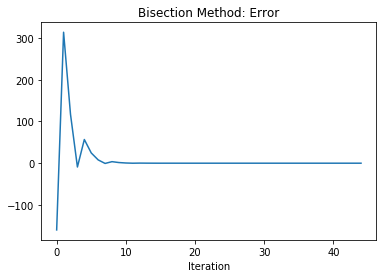

In [7]:
# Graphs
Objective_Bond_A = Objective(price=1000, bond=Bond_A)

# Bisection
Objective_Bond_A.bisection
x = np.arange(len(Objective_Bond_A.error))
plt.plot(x, Objective_Bond_A.error, '-')
plt.title('Bisection Method: Error')
plt.xlabel('Iteration')

Objective_Bond_A.clear_error()

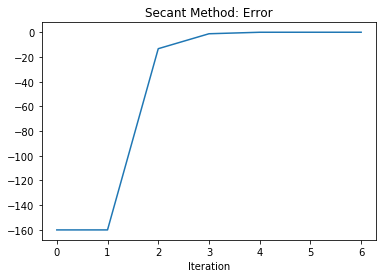

In [8]:
# Secant
Objective_Bond_A.secant
x = np.arange(len(Objective_Bond_A.error))
plt.plot(x, Objective_Bond_A.error, '-')
plt.title('Secant Method: Error')
plt.xlabel('Iteration')
Objective_Bond_A.clear_error()

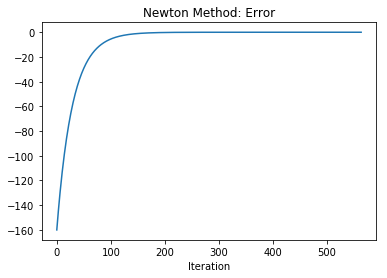

In [9]:
# Newton
Objective_Bond_A.newton
x = np.arange(len(Objective_Bond_A.error))
plt.plot(x, Objective_Bond_A.error, '-')
plt.title('Newton Method: Error')
plt.xlabel('Iteration')
Objective_Bond_A.clear_error()


In [10]:
for index, (maturity, coupon, price) in enumerate(zip(years, coupons, prices)):
    bond = Bond(coupon=coupon, frequency=2, maturity=maturity, notional=100)
    objective = Objective(price=price, bond=bond)
    print("The YTM for bond " + str(index+1) + " is: " + str(objective.bisection) + " %")

The YTM for bond 1 is: 1.1002223624308272 %
The YTM for bond 2 is: 3.8778929392589134 %
The YTM for bond 3 is: 3.386329347833339 %
The YTM for bond 4 is: 4.440582947575535 %
The YTM for bond 5 is: 5.622287626322873 %
